# NLP Notebook 1: Naive IMDB Classifier

In [2]:
%matplotlib inline
import keras

## The IMDB dataset


We'll be working with "IMDB dataset", a set of 50,000 highly-polarized reviews from the Internet Movie Database. They are split into 25,000
reviews for training and 25,000 reviews for testing, each set consisting in 50% negative and 50% positive reviews.

Why do we have these two separate training and test sets? You should never test a machine learning model on the same data that you used to
train it! Just because a model performs well on its training data doesn't mean that it will perform well on data it has never seen, and
what you actually care about is your model's performance on new data (since you already know the labels of your training data -- obviously
you don't need your model to predict those). For instance, it is possible that your model could end up merely _memorizing_ a mapping between
your training samples and their targets -- which would be completely useless for the task of predicting targets for data never seen before.

Just like the MNIST dataset, the IMDB dataset comes packaged with Keras. It has already been preprocessed: the reviews (sequences of words)
have been turned into sequences of integers, where each integer stands for a specific word in a dictionary.

The following code will load the dataset (when you run it for the first time, about 80MB of data will be downloaded to your machine):

In [3]:
from keras.datasets import imdb

vocab_size = 10000
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=vocab_size)

In [4]:
train_data.shape, len(train_data[0]), len(train_data[1])

((25000,), 218, 189)


The argument `num_words=10000` means that we will only keep the top 10,000 most frequently occurring words in the training data. Rare words
will be discarded. This allows us to work with vector data of manageable size.

The variables `train_data` and `test_data` are lists of reviews, each review being a list of word indices (encoding a sequence of words).
`train_labels` and `test_labels` are lists of 0s and 1s, where 0 stands for "negative" and 1 stands for "positive":

In [5]:
train_data[0]

[1,
 14,
 22,
 16,
 43,
 530,
 973,
 1622,
 1385,
 65,
 458,
 4468,
 66,
 3941,
 4,
 173,
 36,
 256,
 5,
 25,
 100,
 43,
 838,
 112,
 50,
 670,
 2,
 9,
 35,
 480,
 284,
 5,
 150,
 4,
 172,
 112,
 167,
 2,
 336,
 385,
 39,
 4,
 172,
 4536,
 1111,
 17,
 546,
 38,
 13,
 447,
 4,
 192,
 50,
 16,
 6,
 147,
 2025,
 19,
 14,
 22,
 4,
 1920,
 4613,
 469,
 4,
 22,
 71,
 87,
 12,
 16,
 43,
 530,
 38,
 76,
 15,
 13,
 1247,
 4,
 22,
 17,
 515,
 17,
 12,
 16,
 626,
 18,
 2,
 5,
 62,
 386,
 12,
 8,
 316,
 8,
 106,
 5,
 4,
 2223,
 5244,
 16,
 480,
 66,
 3785,
 33,
 4,
 130,
 12,
 16,
 38,
 619,
 5,
 25,
 124,
 51,
 36,
 135,
 48,
 25,
 1415,
 33,
 6,
 22,
 12,
 215,
 28,
 77,
 52,
 5,
 14,
 407,
 16,
 82,
 2,
 8,
 4,
 107,
 117,
 5952,
 15,
 256,
 4,
 2,
 7,
 3766,
 5,
 723,
 36,
 71,
 43,
 530,
 476,
 26,
 400,
 317,
 46,
 7,
 4,
 2,
 1029,
 13,
 104,
 88,
 4,
 381,
 15,
 297,
 98,
 32,
 2071,
 56,
 26,
 141,
 6,
 194,
 7486,
 18,
 4,
 226,
 22,
 21,
 134,
 476,
 26,
 480,
 5,
 144,
 30,
 5535,
 18,

In [6]:
train_labels[0]

1

Since we restricted ourselves to the top 10,000 most frequent words, no word index will exceed 10,000:

In [7]:
max([max(sequence) for sequence in train_data])

9999

For kicks, here's how you can quickly decode one of these reviews back to English words. First we create a function to take the first n elements of a dictionary (for display purposes).

In [8]:
from more_itertools import take

def dict_head(dict, n):
  return take(n, dict.items())

In [9]:
# word_index is a dictionary mapping words to an integer index
word_index = imdb.get_word_index()
dict_head(word_index, 5), len(word_index.keys())

([('fawn', 34701),
  ('tsukino', 52006),
  ('nunnery', 52007),
  ('sonja', 16816),
  ('vani', 63951)],
 88584)

#### Exercise 1
**TODO**: Reverse the dictionary content (switch keys and values) and display a review in English (instead of in numbers). Use 'xxunk' for an unknown token in the vocab.

Note: the first 3 indices in the vocab are special tokens.

In [10]:
# We reverse it, mapping integer indices to words
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
dict_head(reverse_word_index, 5)

[(34701, 'fawn'),
 (52006, 'tsukino'),
 (52007, 'nunnery'),
 (16816, 'sonja'),
 (63951, 'vani')]

In [11]:
# We decode the review; note that our indices were offset by 3
# because 0, 1 and 2 are reserved indices for "padding", "start of sequence", and "unknown".
decoded_review = ' '.join([reverse_word_index.get(i - 3, 'xxunk') for i in train_data[0]])
decoded_review

"xxunk this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert xxunk is an amazing actor and now the same being director xxunk father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for xxunk and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also xxunk to the two little boy's that played the xxunk of norman and paul they were just brilliant children are often left out of the xxunk list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for what

## Preparing the data


Next we turn our lists of indices into tensors. There are two ways we could do that - we'll cover more options in more detail later on:

* We could pad our lists so that they all have the same length, and turn them into an integer tensor of shape `(samples, word_indices)`,
then use as first layer in our network a layer capable of handling such integer tensors (the `Embedding` layer, which we will cover in
detail later).
* We could one-hot-encode our lists to turn them into vectors of 0s and 1s. Concretely, this would mean for instance turning the sequence
`[3, 5]` into a 10,000-dimensional vector that would be all-zeros except for indices 3 and 5, which would be ones. Then we could use as
first layer in our network a `Dense` layer, capable of handling floating point vector data.

We will go with the latter solution. Let's vectorize our data, which we will do manually for maximum clarity.

#### Exercise 2
**TODO**: Create a one-hot encoded representation for each review in the train- and test data.

In [12]:
import numpy as np

def vectorize_sequences(sequences, dimension=vocab_size):
    # Create an all-zero matrix of shape (len(sequences), dimension)
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.  # set specific indices of results[i] to 1s
    return results

# Our vectorized training data
x_train = vectorize_sequences(train_data)
# Our vectorized test data
x_test = vectorize_sequences(test_data)

Here's what our samples look like now:

In [13]:
x_train[0]

array([0., 1., 1., ..., 0., 0., 0.])

In [14]:
x_train.shape

(25000, 10000)

We should also vectorize our labels, which is straightforward:

In [15]:
# Our vectorized labels
y_train = np.asarray(train_labels).astype('float32')
y_test = np.asarray(test_labels).astype('float32')

Now our data is ready to be fed into a neural network.

## Building our networks

### Feedforward


Our input data is simply vectors, and our labels are scalars (1s and 0s): this is the easiest setup you will ever encounter. A type of
network that performs well on such a problem would be a simple stack of fully-connected (`Dense`) layers with `relu` activations: `Dense(16,
activation='relu')`

The argument being passed to each `Dense` layer (16) is the number of "hidden units" of the layer. What's a hidden unit? It's a dimension
in the representation space of the layer. You may remember from the previous exercise that each such `Dense` layer with a `relu` activation implements
the following chain of tensor operations:

`output = relu(dot(W, input) + b)`

Having 16 hidden units means that the weight matrix `W` will have shape `(input_dimension, 16)`, i.e. the dot product with `W` will project the
input data onto a 16-dimensional representation space (and then we would add the bias vector `b` and apply the `relu` operation). You can
intuitively understand the dimensionality of your representation space as "how much freedom you are allowing the network to have when
learning internal representations". Having more hidden units (a higher-dimensional representation space) allows your network to learn more
complex representations, but it makes your network more computationally expensive and may lead to learning unwanted patterns (patterns that
will improve performance on the training data but not on the test data).

There are two key architecture decisions to be made about such stack of dense layers:

* How many layers to use.
* How many "hidden units" to chose for each layer.

Later on, you will learn formal principles to guide you in making these choices.
For the time being, you will have to trust us with the following architecture choice:
two intermediate layers with 16 hidden units each,
and a third layer which will output the scalar prediction regarding the sentiment of the current review.
The intermediate layers will use `relu` as their "activation function",
and the final layer will use a sigmoid activation so as to output a probability
(a score between 0 and 1, indicating how likely the sample is to have the target "1", i.e. how likely the review is to be positive).
A `relu` (rectified linear unit) is a function meant to zero-out negative values,
while a sigmoid "squashes" arbitrary values into the `[0, 1]` interval, thus outputting something that can be interpreted as a probability.

Here's what our network looks like:

![3-layer network](https://s3.amazonaws.com/book.keras.io/img/ch3/3_layer_network.png)

And here's the Keras implementation, very similar to the first MNIST example you saw previously:

In [16]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(vocab_size,)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))


Lastly, we need to pick a loss function and an optimizer. Since we are facing a binary classification problem and the output of our network
is a probability (we end our network with a single-unit layer with a sigmoid activation), is it best to use the `binary_crossentropy` loss.
It isn't the only viable choice: you could use, for instance, `mean_squared_error`. But crossentropy is usually the best choice when you
are dealing with models that output probabilities. Crossentropy is a quantity from the field of Information Theory, that measures the "distance"
between probability distributions, or in our case, between the ground-truth distribution and our predictions.

Here's the step where we configure our model with the `rmsprop` optimizer and the `binary_crossentropy` loss function. Note that we will
also monitor accuracy during training.

In [17]:
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

'''
or
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])
'''

"\nor\nmodel.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001),\n              loss='binary_crossentropy',\n              metrics=['accuracy'])\n"

### Training the model

We will now train our model for 20 epochs (20 iterations over all samples in the `x_train` and `y_train` tensors), in mini-batches of 512
samples. At this same time we will monitor loss and accuracy on the 10,000 samples that we set apart. This is done by passing the
validation data as the `validation_data` argument:

In [18]:
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=16,
                    validation_split=0.2)

Epoch 1/10
1250/1250 [==============================] - 8s 5ms/step - loss: 0.3337 - accuracy: 0.8596 - val_loss: 0.2766 - val_accuracy: 0.8906
Epoch 2/10
1250/1250 [==============================] - 4s 3ms/step - loss: 0.2171 - accuracy: 0.9184 - val_loss: 0.2827 - val_accuracy: 0.8912
Epoch 3/10
1250/1250 [==============================] - 4s 3ms/step - loss: 0.1841 - accuracy: 0.9322 - val_loss: 0.2961 - val_accuracy: 0.8910
Epoch 4/10
1250/1250 [==============================] - 5s 4ms/step - loss: 0.1621 - accuracy: 0.9413 - val_loss: 0.3208 - val_accuracy: 0.8880
Epoch 5/10
1250/1250 [==============================] - 4s 3ms/step - loss: 0.1451 - accuracy: 0.9485 - val_loss: 0.3343 - val_accuracy: 0.8848
Epoch 6/10
1250/1250 [==============================] - 4s 3ms/step - loss: 0.1318 - accuracy: 0.9546 - val_loss: 0.3436 - val_accuracy: 0.8812
Epoch 7/10
1250/1250 [==============================] - 5s 4ms/step - loss: 0.1196 - accuracy: 0.9597 - val_loss: 0.3819 - val_accuracy:

On CPU, this will take less than two seconds per epoch -- training is over in 20 seconds. At the end of every epoch, there is a slight pause
as the model computes its loss and accuracy on the 10,000 samples of the validation data.



In [19]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

It contains 4 entries: one per metric that was being monitored, during training and during validation. Let's use Matplotlib to plot the
training and validation loss side by side, as well as the training and validation accuracy:

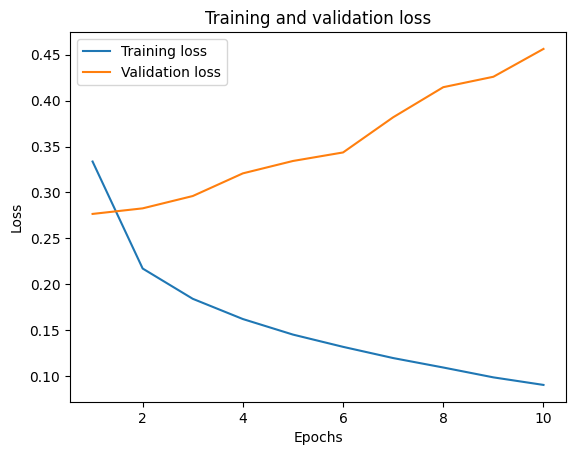

In [20]:
import matplotlib.pyplot as plt

def plot_loss(hist):
  plt.clf()
  loss = hist.history['loss']
  val_loss = hist.history['val_loss']

  epochs = range(1, len(loss) + 1)

  plt.plot(epochs, loss, label='Training loss')
  plt.plot(epochs, val_loss, label='Validation loss')
  plt.title('Training and validation loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()

  plt.show()

plot_loss(history)

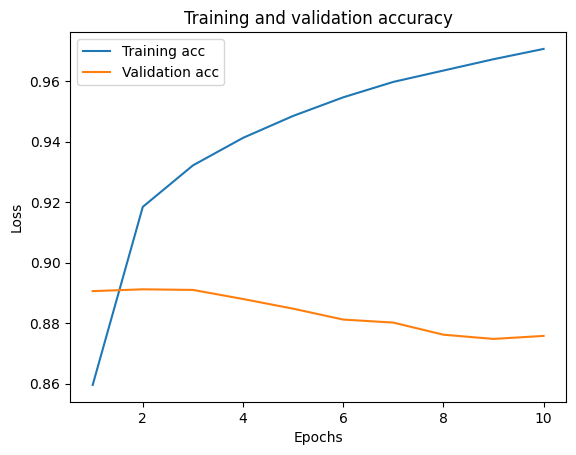

In [21]:
def plot_acc(hist):
  plt.clf()   # clear figure
  acc = hist.history['accuracy']
  val_acc = hist.history['val_accuracy']

  epochs = range(1, len(acc) + 1)

  plt.plot(epochs, acc, label='Training acc')
  plt.plot(epochs, val_acc, label='Validation acc')
  plt.title('Training and validation accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()

  plt.show()

plot_acc(history)

In [ ]:
res = model.evaluate(input_test, test_labels)

Our fairly naive approach achieves an accuracy of around 87%. With state-of-the-art approaches, one should be able to get close to 95%.

### Using a trained network to generate predictions on new data

After having trained a network, you will want to use it in a practical setting. You can generate the likelihood of reviews being positive
by using the `predict` method:

In [22]:
model.predict(x_test)

782/782 [==============================] - 1s 2ms/step


array([[0.05008227],
       [0.99995613],
       [0.00618052],
       ...,
       [0.03951818],
       [0.01064731],
       [0.07434873]], dtype=float32)

As you can see, the network is very confident for some samples (0.99 or more, or 0.01 or less) but less confident for others (0.6, 0.4).


In [23]:
res = model.evaluate(x_test, test_labels)

782/782 [==============================] - 4s 5ms/step - loss: 0.4859 - accuracy: 0.8635


### Embeddings

#### Exercise 3

**TODO**: So far, we've been using one-hot encoded vectors to represent our text. Try to use an embedding layer instead. Check the keras documentation for the specifics of an embedding layer.

All of our reviews have different lengths, and the longest of the bunch is 2494 words long. In order to not have to wait forever, we will limit our maximum review size to 500. This matches the bulk of the reviews' length in the dataset.

In [24]:
max([len(x) for x in train_data])

2494

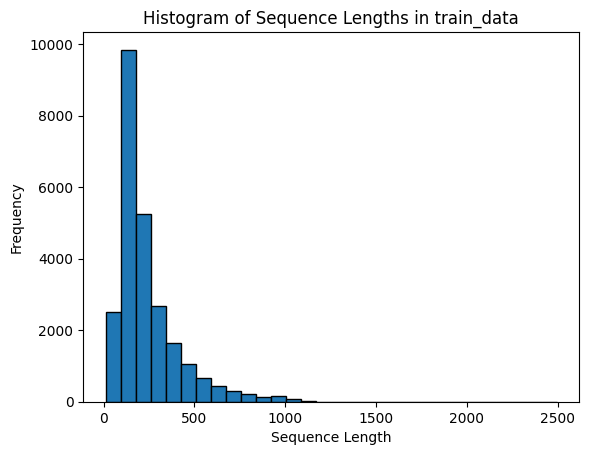

In [25]:
import matplotlib.pyplot as plt

# Assuming train_data is a list of sequences (lists of integers)
lengths = [len(x) for x in train_data]

# Creating a histogram
plt.hist(lengths, bins=30, edgecolor='black')  # Adjust the number of bins as needed
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.title('Histogram of Sequence Lengths in train_data')
plt.show()

In [26]:
from keras.preprocessing import sequence

maxlen = 500

print('Pad sequences (samples x time)')
input_train = sequence.pad_sequences(train_data, maxlen=maxlen)
input_test = sequence.pad_sequences(test_data, maxlen=maxlen)
print('input_train shape:', input_train.shape)
print('input_test shape:', input_test.shape)

Pad sequences (samples x time)
input_train shape: (25000, 500)
input_test shape: (25000, 500)


In [27]:
from keras.layers import Dense, Embedding, Flatten, Dropout
from keras.models import Sequential
from keras.regularizers import l1_l2

embedding_size = 100

# Define L1 and L2 regularization parameters
l1_reg = 0.0001
l2_reg = 0.0001

model = models.Sequential()
model.add(Embedding(vocab_size, embedding_size, input_length=maxlen))
model.add(Flatten())
model.add(layers.Dense(16, activation='elu', kernel_regularizer=l1_l2(l1=l1_reg, l2=l2_reg)))
model.add(layers.Dropout(0.4))
model.add(layers.Dense(1, activation='sigmoid'))

In [28]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 500, 100)          1000000   
                                                                 
 flatten (Flatten)           (None, 50000)             0         
                                                                 
 dense_3 (Dense)             (None, 16)                800016    
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense_4 (Dense)             (None, 1)                 17        
                                                                 
Total params: 1800033 (6.87 MB)
Trainable params: 1800033 (6.87 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [29]:
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [30]:
from keras.regularizers import *
from keras.callbacks import EarlyStopping

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
history = model.fit(input_train, y_train,
                    epochs=20,
                    batch_size=512,
                    validation_split=0.2,
                    callbacks=[es])


Epoch 1/20
40/40 [==============================] - 7s 110ms/step - loss: 0.9941 - accuracy: 0.5209 - val_loss: 0.7948 - val_accuracy: 0.5212
Epoch 2/20
40/40 [==============================] - 4s 108ms/step - loss: 0.7145 - accuracy: 0.6719 - val_loss: 0.6961 - val_accuracy: 0.7404
Epoch 3/20
40/40 [==============================] - 3s 86ms/step - loss: 0.6021 - accuracy: 0.7977 - val_loss: 0.6714 - val_accuracy: 0.7226
Epoch 4/20
40/40 [==============================] - 3s 72ms/step - loss: 0.5286 - accuracy: 0.8402 - val_loss: 0.5593 - val_accuracy: 0.8202
Epoch 5/20
40/40 [==============================] - 2s 62ms/step - loss: 0.4770 - accuracy: 0.8680 - val_loss: 0.5255 - val_accuracy: 0.8338
Epoch 6/20
40/40 [==============================] - 4s 96ms/step - loss: 0.4387 - accuracy: 0.8878 - val_loss: 0.5049 - val_accuracy: 0.8532
Epoch 7/20
40/40 [==============================] - 6s 138ms/step - loss: 0.4105 - accuracy: 0.9032 - val_loss: 0.4843 - val_accuracy: 0.8522
Epoch 8/20

In [31]:
res = model.evaluate(input_test, test_labels)

782/782 [==============================] - 2s 3ms/step - loss: 0.5039 - accuracy: 0.8560


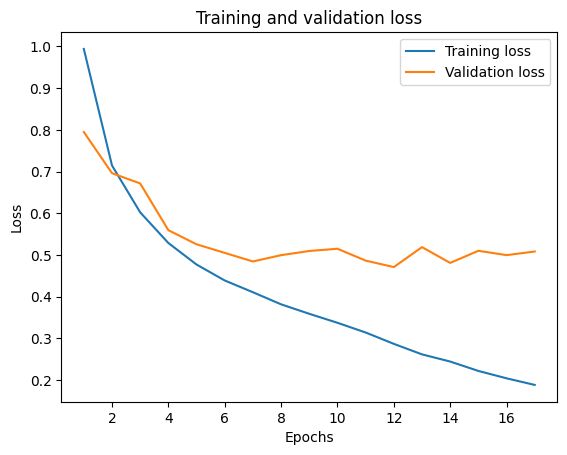

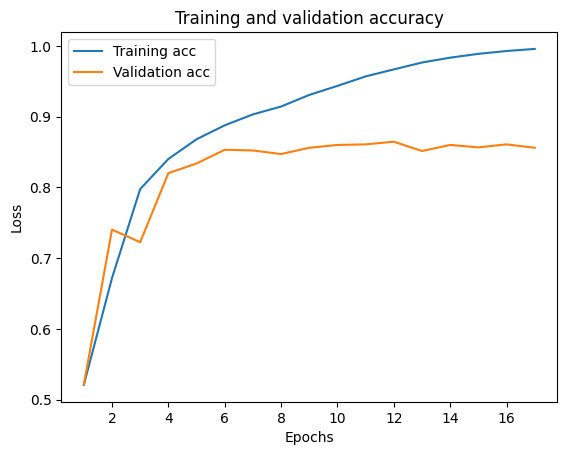

In [32]:
plot_loss(history)
plot_acc(history)

### Recurrent Neural Network

Now we're going to use a recurrent neural network (RNN) for this task. An RNN can handle input sequences of arbitrary length and is good for tasks where the history of a sequence needs to be remembered. For this "simple" classification task it will most probably fall short of the performance of our simple linear neural network above, but when we will be using language models, some kind of recurrent neural network will be our best choice.

RNNs will be further developed in the coming classes.

For now, use the SimpleRNN layer to add a recurring neural network to our model.

In [41]:
from keras.layers import Dense, Embedding, SimpleRNN, Dropout
from keras.models import Sequential

embedding_size = 100

model = Sequential()
model.add(Embedding(vocab_size, embedding_size))
model.add(SimpleRNN(units=64))
model.add(layers.Dense(16, activation='elu', kernel_regularizer=l1_l2(l1=l1_reg, l2=l2_reg)))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

In [42]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, None, 100)         1000000   
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 64)                10560     
                                                                 
 dense_9 (Dense)             (None, 16)                1040      
                                                                 
 dropout_3 (Dropout)         (None, 16)                0         
                                                                 
 dense_10 (Dense)            (None, 1)                 17        
                                                                 
Total params: 1011617 (3.86 MB)
Trainable params: 1011617 (3.86 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [43]:
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [44]:
from keras.regularizers import *
from keras.callbacks import EarlyStopping

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
history = model.fit(input_train, y_train,
                    epochs=20,
                    batch_size=512,
                    validation_split=0.2,
                    callbacks=[es])

Epoch 1/20
40/40 [==============================] - 22s 502ms/step - loss: 0.7023 - accuracy: 0.5459 - val_loss: 0.6834 - val_accuracy: 0.5796
Epoch 2/20
40/40 [==============================] - 24s 600ms/step - loss: 0.5884 - accuracy: 0.7125 - val_loss: 0.8618 - val_accuracy: 0.5258
Epoch 3/20
40/40 [==============================] - 27s 670ms/step - loss: 0.4437 - accuracy: 0.8111 - val_loss: 0.5886 - val_accuracy: 0.7098
Epoch 4/20
40/40 [==============================] - 26s 656ms/step - loss: 0.3309 - accuracy: 0.8719 - val_loss: 0.5514 - val_accuracy: 0.7398
Epoch 5/20
40/40 [==============================] - 23s 587ms/step - loss: 0.2128 - accuracy: 0.9269 - val_loss: 0.6978 - val_accuracy: 0.7214
Epoch 6/20
40/40 [==============================] - 26s 643ms/step - loss: 0.1204 - accuracy: 0.9653 - val_loss: 0.6160 - val_accuracy: 0.7978
Epoch 7/20
40/40 [==============================] - 19s 471ms/step - loss: 0.0960 - accuracy: 0.9742 - val_loss: 0.8011 - val_accuracy: 0.7344

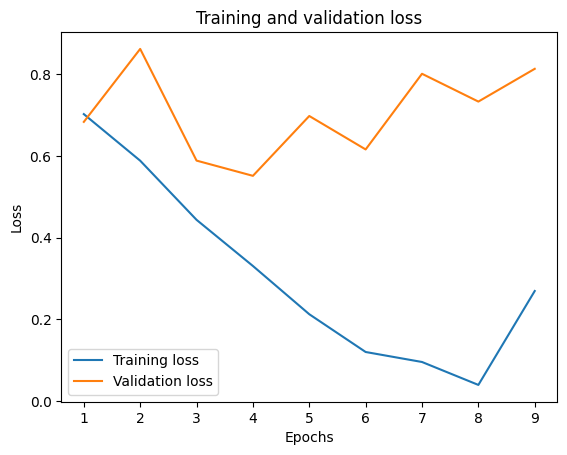

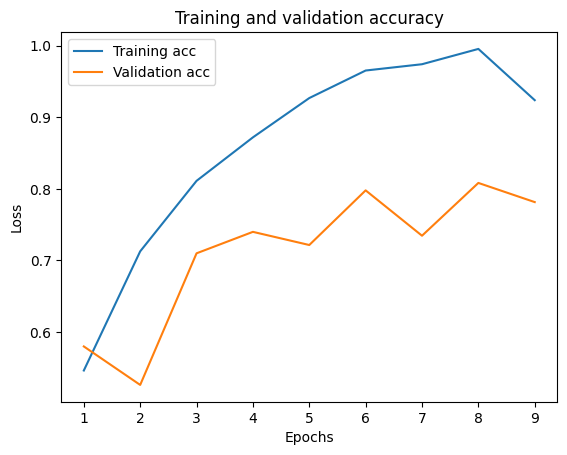

In [45]:
plot_loss(history)
plot_acc(history)

In [ ]:
res = model.evaluate(input_test, test_labels)

As a reminder, our very first naive approach to this very dataset got us to 88% test accuracy. Unfortunately, our small
recurrent network doesn't perform very well at all compared to this baseline (only up to 85% validation accuracy). Part of the problem is
that our inputs only consider the first 500 words rather the full sequences --
hence our RNN has access to less information than our earlier baseline model. The remainder of the problem is simply that `SimpleRNN` isn't very good at processing long sequences, like text.

#### Exercise 5
**TODO**: Use pretrained word embeddings to optimize your model even further.

In [40]:
import requests

def download_glove(url, save_path):
    response = requests.get(url)
    with open(save_path, 'wb') as f:
        f.write(response.content)

# URL for GloVe embeddings (replace with the actual URL)
glove_url = 'https://nlp.stanford.edu/data/glove.6B.zip'

# Path to save the GloVe file
save_path = 'glove.6B.zip'

# Downloading the file
download_glove(glove_url, save_path)

# Note: After downloading, you may need to unzip the file.


In [46]:
!unzip glove.6B.zip

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [47]:
import numpy as np
from keras.models import Sequential
from keras.layers import Embedding, SimpleRNN, Dense
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import numpy as np
from keras.optimizers import Nadam, Adam
from keras.callbacks import LearningRateScheduler


In [49]:

glove_path = 'glove.6B.100d.txt'

embedding_dim = 100  #embedding dimension based on the GloVe file

embedding_index = {}
with open(glove_path, encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = coefs

# Create a matrix for the embedding layer
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in word_index.items():
    if i < vocab_size:
        embedding_vector = embedding_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

In [57]:
from keras.layers import LSTM, BatchNormalization
from keras.regularizers import l1_l2

# Maximum review size
max_review_length = 500

# Create the Sequential model
model = Sequential()

# Add an Embedding layer with pre-trained weights
model.add(Embedding(input_dim=vocab_size,
                    output_dim=embedding_dim,
                    input_length=max_review_length,
                    weights=[embedding_matrix],
                    trainable=True))

# Add an LSTM layer with dropout and recurrent dropout
model.add(LSTM(units=64, dropout=0.2, return_sequences=True))  # Reduced number of units

# Add an LSTM layer with dropout and recurrent dropout
model.add(LSTM(units=64, dropout=0.2))  # Reduced number of units

# Add a Dense layer with L1 and L2 regularization
model.add(Dense(units=16, activation='elu', kernel_regularizer=l1_l2(l1=l1_reg, l2=l2_reg)))

# Add another Dropout layer
model.add(Dropout(0.2))

# Final Dense layer for classification
model.add(Dense(units=1, activation='sigmoid'))

In [58]:
# Compile the model with the initial learning rate
model.compile(optimizer="rmsprop",
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Display the model summary
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 500, 100)          1000000   
                                                                 
 lstm_6 (LSTM)               (None, 500, 64)           42240     
                                                                 
 lstm_7 (LSTM)               (None, 64)                33024     
                                                                 
 dense_13 (Dense)            (None, 16)                1040      
                                                                 
 dropout_5 (Dropout)         (None, 16)                0         
                                                                 
 dense_14 (Dense)            (None, 1)                 17        
                                                                 
Total params: 1076321 (4.11 MB)
Trainable params: 1076

In [59]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
history = model.fit(input_train, y_train,
                    epochs=50,
                    batch_size=512,
                    validation_split=0.2,
                    callbacks=[es])

Epoch 1/50
40/40 [==============================] - 10s 146ms/step - loss: 0.7093 - accuracy: 0.5215 - val_loss: 0.7276 - val_accuracy: 0.4938
Epoch 2/50
40/40 [==============================] - 5s 135ms/step - loss: 0.7023 - accuracy: 0.5441 - val_loss: 0.7302 - val_accuracy: 0.5084
Epoch 3/50
40/40 [==============================] - 5s 126ms/step - loss: 0.6938 - accuracy: 0.5716 - val_loss: 0.6863 - val_accuracy: 0.5780
Epoch 4/50
40/40 [==============================] - 5s 128ms/step - loss: 0.6795 - accuracy: 0.5976 - val_loss: 0.6944 - val_accuracy: 0.5648
Epoch 5/50
40/40 [==============================] - 5s 128ms/step - loss: 0.6643 - accuracy: 0.6187 - val_loss: 0.6319 - val_accuracy: 0.6556
Epoch 6/50
40/40 [==============================] - 5s 118ms/step - loss: 0.6471 - accuracy: 0.6410 - val_loss: 0.6710 - val_accuracy: 0.6216
Epoch 7/50
40/40 [==============================] - 5s 125ms/step - loss: 0.6278 - accuracy: 0.6605 - val_loss: 0.6088 - val_accuracy: 0.6754
Epoch

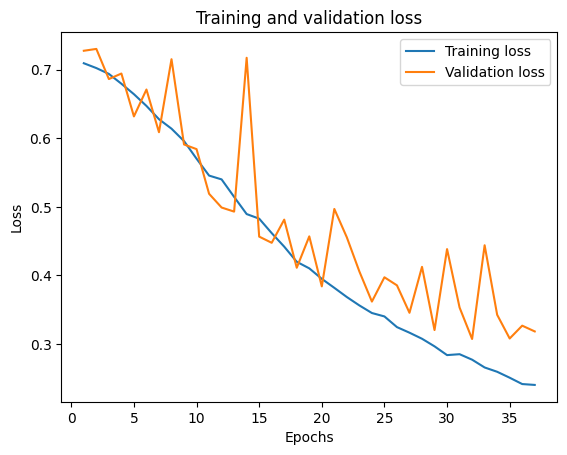

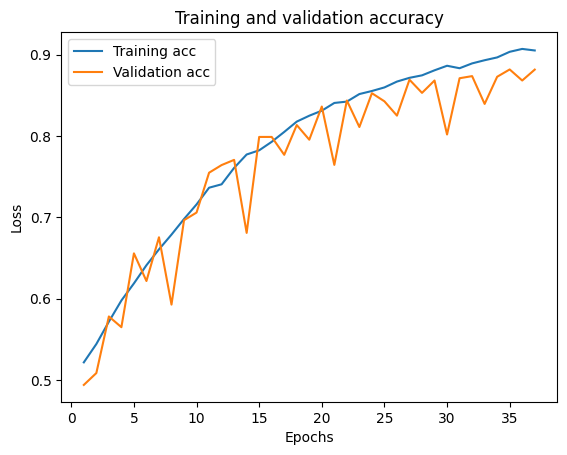

In [60]:
plot_loss(history)
plot_acc(history)

In [61]:
res = model.evaluate(input_test, test_labels)

782/782 [==============================] - 12s 14ms/step - loss: 0.3303 - accuracy: 0.8777


#### Exercise 6

Come up with your own ways to improve your accuracy. You are free to use whatever you like:
* Other optimizations or embeddings
* LSTMs
* Transformers
* LLMs